<img src="Outlier_Detection_header.png" width="100%" />


##  Objective
In this notebook, as a second approach, we aim to develop machine learning models capable of identifying erroneous data points within our ornithological datasets. The primary objective of this notebook is to establish the modeling pipeline, making it easier to integrate subsequent optimizations based on our evaluation investigations.

Unlike our previous approach that primarily focused on temporal and spatial information through Emergent Filters, this machine learning approach employs baseline anomaly detection algorithms such as Isolation Forests, DBSCAN, and One-Class SVM, which enable us to incorporate more sophisticated features, including those provided by ornitho.de (such as Atlas Code) and self-created features derived from them (like land use and altitude) into the anomaly detection process. We anticipate that the incorporation of such supplementary information will render more precise validity assessments of the data point.

## Scope
Our investigation in this notebook aims to achieve two significant outcomes. Firstly, we intend to distinguish between valid and invalid data points using afore-mentioned anomaly detection algorithms. Secondly, we aim to augment our anomaly detection process with interpretability. We employ Shapley values to unravel the decision-making process of our models, pinpointing the pivotal features that lead to the classification of a data point as erroneous. This transparent approach not only provides valuable insights for model evaluation but also potentially provides additional assistance to reviewers during error assessment.

## Limitation
The evaluation and optimization of the employed models, including hyperparameter optimization and finegrained feature selection, is not within the scope of this notebook since at the time this notebook was employed, no evaluation data was available. It will be conducted in the future in the chapter *04_evaluation* as part of the *Hauptprojekt*.

In [1]:
%%HTML
<style>
    body {
        --vscode-font-family: "Itim"
    }
</style>

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
import plotly.express as px
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
from pyod.models.auto_encoder import AutoEncoder


from utils.data_preparation import *
from simon.utils.feature_generation import *

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
2023-12-13 19:03:50.185242: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 0️⃣ Specify your paths
In order to run the notebook, the following file is required:
- Master dataset reduced to 27 species and enriched with EEA grids and land uses: *[selected_species_50km_luse.csv](https://drive.google.com/drive/folders/18XoTsDtWnN4QdIBNGGbq-jaa6U3nVb2e)*
- Validation set including unlabeled erreneous data: *[validata_ch_with_luse_and_gt.csv](https://drive.google.com/drive/folders/1emvbXc5ExoEgv7Pmwy_Y5rjNc9k8hrNs)*

If you wish to store the resulting Emergent Filter lookup table for later predictions (in pkl format), please specify a target path where it should be stored.

In [2]:
path_train = '../../../01_Data/datasets/selected_species_50km_luse.csv'  # Provide local path to selected_species_50km_luse.csv
path_validata = '../../../01_Data/datasets/validata_ch_with_luse_and_gt.csv'  # Provide local path to validata_ch_with_luse_and_gt.csv

target_path = 'model_output.csv'

## 1️⃣ Load data

For this notebook, we are using the standardized dataset containing bird sightings data from both Switzerland and Germany spanning from 2018 to 2022. It already contains our self-generated features `eea_grid_id`, `altitude`, and `land_use`.

Additionally, we apply the validation dataset provided by ornitho.ch and ornitho.de for evaluation, comprising both correct and manually falsified data points from 2023.

In [21]:
train_data = pd.read_csv(path_train, index_col=0, low_memory=False).reset_index(drop=True)
validata = pd.read_csv(path_validata, index_col=0, low_memory=False).reset_index(drop=True)

## 2️⃣ Data preparation 

###  1. Data selection: The water pipit
Recognizing the intricate diversity of bird species, it becomes evident that each bird species possesses its own distinctive set of behaviors and preferences. For instance, migration times and preferred habitats exhibit substantial variations among different species.
Therefore, as discussed with the ornithologists, we refrained from training a single model for multiple species to avoid generalization errors. Instead, individualized models will be developed for each bird species. By adopting this approach, we aim to capture the specific patterns inherent to each species, ensuring that our conclusions about the validity of bird sightings are grounded in the nuanced understanding of each species' behavior.

We have chosen to prototype our model implementation for the water pipit (ger. *Bergpieper*, depicted below), one of the 27 bird species selected by ornitho.de and ornitho.ch, as it has a medium occurrence frequency in our dataset.


<img src="https://www.lfu.bayern.de/natur/sap/arteninformationen/bild/zeige/224838" alt="A water pipit." style="border-radius: 7px;/">

In [22]:
bergpieper_train = train_data[train_data.name_species == 'Bergpieper']
bergpieper_test = validata[validata.name_species == 'Bergpieper']

In [5]:
bergpieper_train.head(2)

,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,total_count,atlas_code,id_observer,country,eea_grid_id,Numerical_LUSE,LUSE
12,29658979,469.0,Bergpieper,2018-01-01,NaN,52.321750,10.432800,place,67.174774,2.0,0,106288.0,de,50kmE4350N3200,3,Agriculture
30,29661644,469.0,Bergpieper,2018-01-01,NaN,49.144776,10.690435,square,414.630200,3.0,0,70588.0,de,50kmE4350N2850,3,Agriculture


In [6]:
bergpieper_test.head(2)

,id_validata,id_sighting,id_species,name_species,date,timing,coord_lat,coord_lon,precision,altitude,...,atlas_code,id_observer,eea_grid_id,Numerical_LUSE,LUSE,date_original,coord_lat_original,coord_lon_original,altitude_original,change_type
16,17,NaN,469,Bergpieper,2023-07-10,NaN,47.567153,7.551575,square,280.0,...,0,9110,50kmE4100N2700,3,Agriculture,45026,47.567153,7.551575,280.0,date
509,510,NaN,469,Bergpieper,2023-03-25,10:02:32,46.155468,8.865485,precise,190.0,...,0,1504,50kmE4200N2550,6,Water,25/03/23,46.155468,8.865485,NaN,NaN


### 2. Feature selection
Not all features in the dataset depicted above are considered suitable or informative for the outlier analysis. Consequently, we exclude the following features from consideration, as they do not provide additional information for assessing validity:
- `id_validata`
- `id_sighting`
- `id_species`
- `name_species`
- `precision`
- `id_observer`

Furthermore, due to the feature's sparsity in the training dataset, we exclude the features `timing` (59.3% unspecified) and `atlas_code` (78.1.6% unspecified) from our analysis:

In [8]:
print('Percentage of unspecified timing feature:', train_data.timing.isna().sum() / len(train_data))
grouped_atlas_codes = condense_atlas_codes(train_data.atlas_code)
print('Percentage of unspecified atlas code feature:', (grouped_atlas_codes == 0).sum() / len(train_data))

Percentage of unspecified timing feature: 0.5928272588074704
Percentage of unspecified atlas code feature: 0.780635501005059


We also omit `eea_grid_id`, as the spatial information is also already depicted more precisely in `coord_lat` and `coord_lon`.

Lastly, we remove `LUSE` as it holds the same information as `NumericalLUSE` but as string literals.

All other features will be incorporated to our outlier analysis:

In [23]:
bergpieper_train = bergpieper_train[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count','Numerical_LUSE']]
bergpieper_test = bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count', 'Numerical_LUSE']]
bergpieper_train.head()

,date,coord_lat,coord_lon,altitude,total_count,Numerical_LUSE
12,2018-01-01,52.321750,10.432800,67.174774,2.0,3
30,2018-01-01,49.144776,10.690435,414.630200,3.0,3
39,2018-01-01,51.022837,6.208935,48.621960,1.0,3
41,2018-01-01,51.022837,6.208935,48.621960,1.0,3
44,2018-01-01,49.872006,12.239931,469.780550,2.0,3


### 3. Feature preparation
Before modeling with the data, some preparatory steps need to be taken:

Each date is converted to its respective day of year to convert it to a numerical value.

In [24]:
# remove all rows with altitude = min value of altitudes
bergpieper_train = bergpieper_train[bergpieper_train.altitude != bergpieper_train.altitude.min()]

In [25]:
# Turn date into day of year
bergpieper_train.date = pd.to_datetime(bergpieper_train.date).dt.dayofyear
bergpieper_test.date = pd.to_datetime(bergpieper_test.date).dt.dayofyear

The `land_use` feature is a categorical feature. To prevent models from assuming an ordinal relationship between the land use categories, one-hot encoding is applied, creating binary columns for each distinct land use category.

In [27]:

land_uses = bergpieper_train['Numerical_LUSE'].unique()

bergpieper_train = pd.get_dummies(bergpieper_train, columns=['Numerical_LUSE'], dtype=int)
bergpieper_test = pd.get_dummies(bergpieper_test, columns=['Numerical_LUSE'], dtype=int)

for land_use in land_uses:
    category = 'Numerical_LUSE_' + str(land_use)
    if category not in bergpieper_test.columns:
        bergpieper_test[category] = 0

In [28]:
# Replace NaNs in total_count with 1 (default value)
bergpieper_train.total_count = bergpieper_train.total_count.fillna(1)
bergpieper_test.total_count = bergpieper_test.total_count.fillna(1)

In [29]:
# Normalize features between 0 and 1
scaler = MinMaxScaler()
bergpieper_train = pd.DataFrame(scaler.fit_transform(bergpieper_train), columns=bergpieper_train.columns)
bergpieper_test = pd.DataFrame(scaler.fit_transform(bergpieper_train), columns=bergpieper_train.columns)

In [30]:
bergpieper_train.head()

,date,coord_lat,coord_lon,altitude,total_count,Numerical_LUSE_1,Numerical_LUSE_2,Numerical_LUSE_3,Numerical_LUSE_4,Numerical_LUSE_5,Numerical_LUSE_6,Numerical_LUSE_8
0,0.0,0.697950,0.509848,0.021753,0.002151,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.359307,0.537404,0.117553,0.003226,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.559495,0.058083,0.016637,0.001075,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.559495,0.058083,0.016637,0.001075,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.436825,0.703131,0.132759,0.002151,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 2️⃣ Modeling
Our objective is to formulate an outlier detection model proficient in identifying bird sightings that deviate from the species' norms. This model will be exclusively trained on valid data points spanning from 2018 to 2022. Subsequently, we will assess its proficiency in identifying outliers using a curated test dataset from 2023 which has been augmented with anomalies introduced by the ornithologists.

Three commonly used outlier algorithms will be trained: Isolation Forest, Local Outlier Factor, and One-Class SVM, initially with their default hyperparameters. These can be tuned and adjusted in a subsequent deep-dive. After training, the models predict whether a data point in the validation dataset is an valid (=1) or possibly faulty (=-1). For each algorithm, the percentage of recognized outlier models is returned.

In [16]:
dbscan = DBSCAN(eps=2, min_samples=5)
prediction_dbscan = dbscan.fit_predict(bergpieper_test)  # outliers=-1
prediction_dbscan[prediction_dbscan != -1] = 1  # inliers=1
outliers_dbscan = bergpieper_test[prediction_dbscan == -1]

print('Number of detected anomalies:', len(outliers_dbscan), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_dbscan)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 429 / 6431
Percentage of anomalies: 6.67 %


In [17]:
isolation_forest = IsolationForest(contamination='auto', random_state=0)
isolation_forest.fit(bergpieper_train)

prediction_if = isolation_forest.predict(bergpieper_test)  # inliers=1; outliers=-1
outliers_if = bergpieper_test[prediction_if == -1]

print('Number of detected anomalies:', len(outliers_if), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_if)/len(bergpieper_test)*100,2), '%')

Number of detected anomalies: 3026 / 6431
Percentage of anomalies: 47.05 %


In [18]:
ae = AutoEncoder(hidden_neurons=[10, 2, 10], epochs=10, verbose=0)
ae.fit(bergpieper_train)
display(ae.get_params())
y_pred = ae.predict(bergpieper_test)

prediction_ae = ae.predict(bergpieper_test)
prediction_ae[prediction_ae == 1] = -1  # outliers=-1
prediction_ae[prediction_ae == 0] = 1  # inliers=1;


outliers_ae = bergpieper_test[prediction_ae == -1]

print('Number of detected anomalies:', len(outliers_ae), '/', len(bergpieper_test))
print('Percentage of anomalies:', round(len(outliers_ae)/len(bergpieper_test)*100,2), '%')

3366/3366 [==============================] - 4s 1ms/step


{'batch_size': 32,
 'contamination': 0.1,
 'dropout_rate': 0.2,
 'epochs': 10,
 'hidden_activation': 'relu',
 'hidden_neurons': [10, 2, 10],
 'l2_regularizer': 0.1,
 'loss': <function keras.src.losses.mean_squared_error(y_true, y_pred)>,
 'optimizer': 'adam',
 'output_activation': 'sigmoid',
 'preprocessing': True,
 'random_state': None,
 'validation_size': 0.1,
 'verbose': 0}

201/201 [==============================] - 0s 1ms/step
Number of detected anomalies: 648 / 6431
Percentage of anomalies: 10.08 %


## 3️⃣ Add interpretability with Shapley
In order to gain an initial insight into the internal functioning of the models, we employ Shapley values. Shapley values offer a systematic methodology for comprehending the significance of features within the model's decision-making process.

Additionally, we aim to utilize Shapley values to identify, on a per-data-point basis, which feature has predominantly contributed to the model categorizing a data point as an outlier. This approach could assist reviewers in pinpointing the potential source of error within the data point.

For demonstration, we apply Shapley interpretability for the Isolation Forest. 

### 1. Feature importance across all data points
The summary plot provides an overview of the feature importance for each feature in the model's predictions, where the vertical bars represent the mean magnitude of the SHAP values for each feature.

We observe that the altitude of the points had the most significant explanatory power. Similarly, both the number of birds and land use appear to have a significant influence on the model's predictions. 

The informativeness of a feature provides insights into which features were influential for model predictions. However, it needs to be emphasized that the conclusions drawn based on these features may not necessarily be accurate. Once labeled data is accessible, it can be verified whether the outliers identified through these influential features were correctly recognized, and assumptions can be made accordingly.

 98%|===================| 6294/6431 [00:34<00:00]        

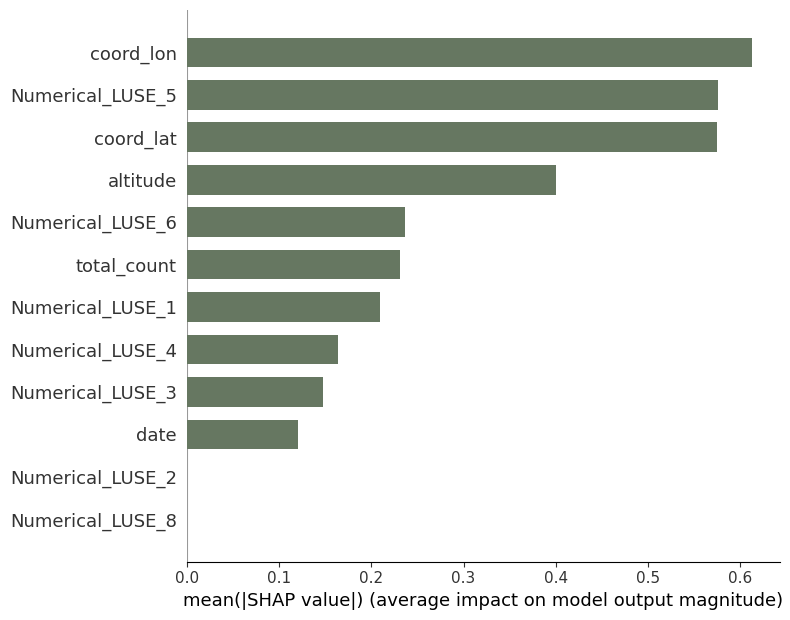

In [19]:
explainer_if = shap.Explainer(isolation_forest, bergpieper_test)
shap_values_if = explainer_if.shap_values(bergpieper_test)
shap.summary_plot(shap_values_if, bergpieper_test, plot_type='bar', color='#667761')

Permutation explainer: 6432it [11:09,  9.47it/s]                          


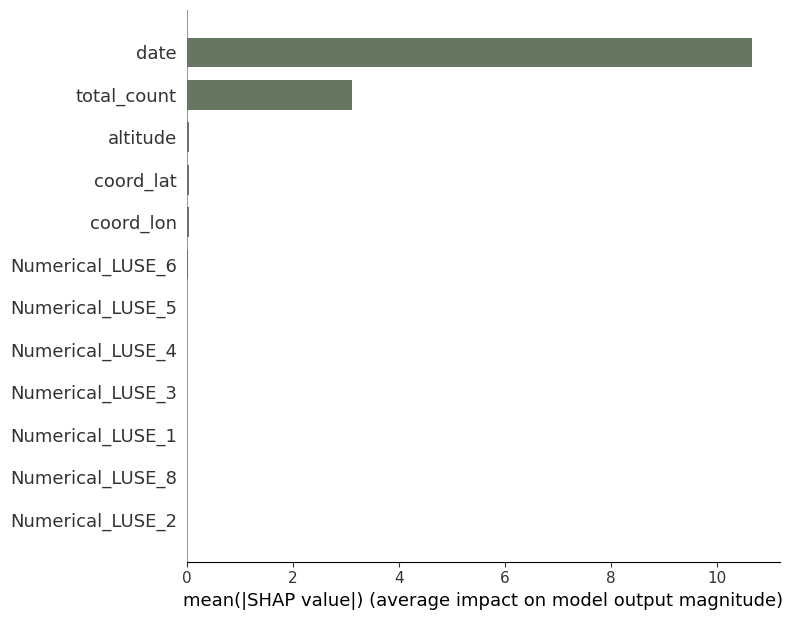

In [20]:
explainer = shap.Explainer(dbscan.fit_predict, bergpieper_test)
shap_values = explainer.shap_values(bergpieper_test)
shap.summary_plot(shap_values, bergpieper_test, plot_type='bar', color='#667761')

In [ ]:
explainer = shap.Explainer(ae.predict, bergpieper_test)
shap_values = explainer.shap_values(bergpieper_test)

In [ ]:
shap.summary_plot(shap_values, bergpieper_test, plot_type='bar', color='#667761')

### 2. Feature importance for a specific data point

With Shapley, it is also possible to display a bar plot specifically illustrating the contribution of individual features to the prediction for that particular data point.
From the plot, we can derive:
- **Feature Importance Magnitude:** The height of each bar represents the magnitude of the SHAP values for a specific feature with respect to the prediction for the given data point. A taller bar indicates a feature's higher impact on the prediction for that specific instance.

- **Direction of Impact:** The color of the bars can indicate the direction of the impact of each feature on the prediction. Positive impact (features contributing to a higher prediction) might be a different color from negative impact (features contributing to a lower prediction).

Below, a single sighting of a water pipit is chosen and a Shapley bar plot is created:

In [22]:
bergpieper_test.iloc[4]

date                31.000000
coord_lat            0.164523
coord_lon            0.637967
altitude             0.000000
total_count          1.000000
Numerical_LUSE_1     0.000000
Numerical_LUSE_2     0.000000
Numerical_LUSE_3     0.000000
Numerical_LUSE_4     0.000000
Numerical_LUSE_5     0.000000
Numerical_LUSE_6     1.000000
Numerical_LUSE_8     0.000000
Name: 512, dtype: float64

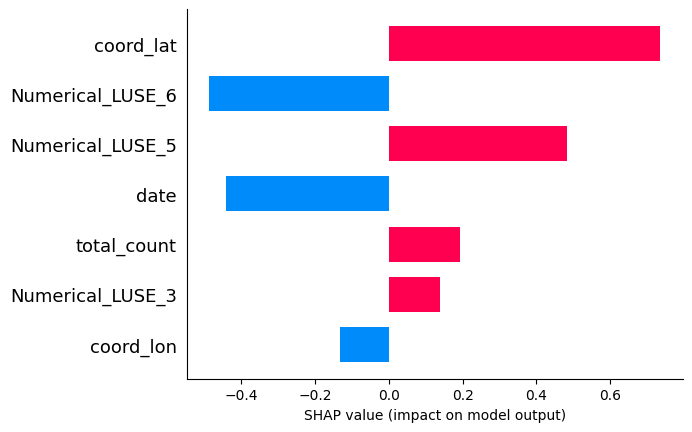

In [23]:
shap.initjs()
shap_values_dp = explainer_if.shap_values(bergpieper_test.iloc[4])
shap.bar_plot(shap_values_dp, feature_names=bergpieper_test.columns)

In the presented plot, it is evident that the model identifies the date, latitude, and land use as atypical factors, pulling the data point closer to an outlier classification. Conversely, altitude, longitude, and count values appear unremarkable, not suggesting an outlier scenario. Upon examining the data point, it is notable that the water pipit was observed on January 31st, a time in the midst of winter when water pipit sightings are possible, but infrequent. Additionally, this observation occurred in the southernmost region of Switzerland. Consequently, the latitude value falls at the lower boundary of all training data due to the absence of data south of Switzerland.

Furthermore, the land use code 6 corresponds to "Water." While a sighting on water is theoretically feasible, it remains implausible according to the Shapley values. This implausibility results in a slightly negative Shapley value. 

As the cumulative negative Shapley values outweigh the positive ones, this data point has been designated as an outlier.

## 4️⃣ Output generation
As an output, we append the model's prediction of outlierness along with complimentary features that will enable a more comprehensive evaluation.

### 1. Add predictions
First, the validation dataset is enriched with the binary outlier predictions of the models.

In [24]:
bergpieper_output = validata[validata.name_species == 'Bergpieper'].copy()

In [23]:
# Add outlier prediction
prediction = dbscan.fit_predict(bergpieper_test)
prediction[prediction != -1] = 0  # inliers=0
prediction[prediction == -1] = 1  # outliers=1
bergpieper_output['error_detected'] = prediction
bergpieper_output.to_csv('dbscan_predictions.csv')

In [24]:
# Add outlier prediction
bergpieper_output['error_detected'] = isolation_forest.predict(bergpieper_test)  # inlier 1 -> 0; outlier -1 -> 1
bergpieper_output['error_detected'] = bergpieper_output.error_detected.replace({1: 0, -1: 1})

In [25]:
bergpieper_output['error_detected'] = ae.predict(bergpieper_test)

201/201 [==============================] - 1s 4ms/step


### 2. Add hint to most likely error source
Also, to deliver the name of the feature that contributed the most to the datapoint being labeled as outlier, an additional column is introduced. In the event of an outlier, this column captures the feature associated with the most negative Shapley value.

In [25]:
# Add most likely error source
feature_names = bergpieper_test.columns
outliers = bergpieper_output[bergpieper_output.error_detected == 1]
error_sources = []

for shaps in shap_values_if:
    if min(shaps) >=0:
        error_sources.append('None')
    else:
        feature_index = np.argmin(shaps)
        feature_name = feature_names[feature_index]
        error_sources.append(feature_name)

bergpieper_output['most_likely_error_source'] = error_sources
bergpieper_output.loc[bergpieper_output.error_detected == 0, 'most_likely_error_source'] = 'None'

### 3. Add the model's prediction confidence
Lastly, information about the predictions confidence is added, which can be extracted from the decision function of the model.

In the context of an Isolation Forest model, the decision function score represents the anomaly score for a data point. A more negative decision function score indicates a higher likelihood of the data point being an outlier according to the model.

In [26]:
anomaly_scores = isolation_forest.decision_function(bergpieper_test)
bergpieper_output['anomaly_score'] = anomaly_scores

In [26]:
bergpieper_output['anomaly_score'] = ae.decision_function(bergpieper_test)

201/201 [==============================] - 0s 2ms/step


The final output will be stored under the provided path:

In [27]:
bergpieper_output.to_csv(target_path)

## 5️⃣ Initial model assessment - Visualizing the results
As a first initial assessment of the models results, we will provide a visual representation of the Isolation Forest's predictions.

### 1. Visualization of all data points and their most likely error sources
Below, all data points from the validation dataset are presented with respect to the date and location of the sighting. Inliers are denoted in gray; outliers are color-coded according to their most likely error source.

It is noteworthy to observe that error points identified as outliers based on their date consistently occurr either at the beginning or the end of the year, during the winter season. Similarly, outliers identified due to latitude or longitude values are consistently located at the lower or upper boundary of the features values. This indicates a proper functioning of the Isolation Forest, as it correctly identifies and classifies outlying points.

In [160]:
fig = px.scatter_3d(bergpieper_output, x='date', y='coord_lon', z='coord_lat', color='most_likely_error_source',
                    opacity=0.7, width=800, height=600,
                    labels={'date': 'Date', 'coord_lon': 'Longitude', 'coord_lat': 'Latitude'},
                    title='Outlier Detection',
                    color_discrete_map={'None': '#d9d9d9'})

fig.update_traces(marker={'size': 3})   
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Outlier Detection", xanchor='center'),
                  legend_title_text='Most Likely Error Source')

fig.show()

### 2. XXXXX

In [28]:
bergpieper_pred = bergpieper_test[['date', 'coord_lat', 'coord_lon', 'altitude', 'total_count', 'NumericalLUSE']].copy()

for predictions, name in zip([prediction_dbscan, prediction_if, prediction_ae], ['DBSCAN', 'Isolation Forest', 'Autoencoder']):
    bergpieper_pred['Error Detected?'] = predictions
    bergpieper_pred['Error Detected?'] = bergpieper_pred['Error Detected?'].replace({1:'Datapoint OK', -1: 'Outlier'})
    g = sns.pairplot(bergpieper_pred, hue='Error Detected?', palette=['#ee6055', '#55a630'], height=1, plot_kws={"s": 4})
    g.fig.suptitle(name, y=1.05, fontsize=24)


KeyError: "['NumericalLUSE'] not in index"

### 2. Distribution of most likely error sources
The distribution of most likely error sources aligns closely with the previously determined feature importances from Shapley values. The most common error sources, namely total count, land use, and altitude, are relatively evenly represented.

In [30]:
fig = px.pie(bergpieper_output, values='error_detected', names='most_likely_error_source', title='Error sources', color_discrete_sequence=['#667761', '#b79492', '#756460'])
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text='Distribution of most likely error sources', xanchor='center'),
                  legend_title_text='Most Likely Error Source',
                  width=800, height=600)
fig.show()

### 3. Distribution of the model's anomaly scores
The decision function provides insights into the prediction confidence of the model. We observe that the confidences are roughly distributed following a normal distribution around ~0.07. Additionally, a significant number of inliers have been labeled as such with low confidence. To mitigate the occurrence of false negatives (where a data point is incorrectly labeled as correct), the threshold could be increased from 0 to a higher value. This adjustment would entail labeling inliers, identified with low confidence, as outliers as well. This modification is planned for a subsequent study.

In [40]:
histogram = bergpieper_output.copy()
histogram['error_detected'] = histogram.error_detected.replace(({0: 'No - Datapoint OK', 1: 'Yes - Anomaly Detected'}))
fig = px.histogram(histogram, x='anomaly_score', 
                   nbins=100, marginal='box', 
                   color='error_detected', 
                   color_discrete_sequence=['#55a630', '#ee6055'],
                   labels={'anomaly_score': 'Anomaly Score', 'error_detected': 'Error Detected'},
                   )
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Anomaly Scores Distribution", xanchor='center'),
                  legend_title_text='Our Prediction')

fig.show()

NameError: name 'bergpieper_output' is not defined

In [41]:
histogram = bergpieper_test.copy()
histogram['anomaly_score'] = ae.decision_function(bergpieper_test)
histogram['error_detected'] = prediction_ae
histogram['error_detected'] = histogram.error_detected.replace(({0: 'No - Datapoint OK', 1: 'Yes - Anomaly Detected'}))
fig = px.histogram(histogram, x='anomaly_score', 
                   nbins=100, marginal='box', 
                   color='error_detected', 
                   color_discrete_sequence=['#55a630', '#ee6055'],
                   labels={'anomaly_score': 'Anomaly Score', 'error_detected': 'Error Detected'},
                   )
fig.update_layout(font=dict(family="Aleo", size=10, color="#4d5f81"),
                  title=dict(x=0.5, y=0.95, font=dict(size=24), text="Anomaly Scores Distribution", xanchor='center'),
                  legend_title_text='Our Prediction')

fig.show()

201/201 [==============================] - 0s 2ms/step


## 6️⃣  Outlook
In this notebook, we prepared the data for outlier analysis using machine learning algorithms, trained corresponding models, and conducted an initial assessment. A comprehensive evaluation of the suitability for our bird dataset, including other bird species, can only be performed upon obtaining access to the labels of the test data. Upon receipt, we will provide a notebook in Chapter 04_evaluation for an in-depth analysis of the models and assess whether the methodology employed is suitable for detecting implausible bird sightings.